<h1>Automatic Identification of Lithology using Machine Learning Approach</h1>

**Team 4 (Ahmed H. Gowida, Mahmoud H. Desouky, Abdullah M. Alqubalee)**

<i>Email Addresses:
AHG: g201708730@kfupm.edu.sa
MHD: g201706310@kfupm.edu.sa
AMA: g201304210@kfupm.edu.sa<i>




**Part two : ML-Modles**

# Overview

## The parameters categories:

- **Booster** Parameters
        - eta: learining rate which makes the model more robust by shrinking the weight on each step.
        - alpha/lambda: regularization parameters like LASSO and Ridge
        - gamma: split occurs only when there is a positive reduction in loss fxn
        - min_child_weight
        - max_depth
        - max_leaf_nodes
        - max_delta_step
        - subsample: random fraction of observations for each tree
        - colsample_bytree/colsample_bylevel: fraction of features for each tree/split
        - scale_pos_weight: >0 should be used for faster convergence in high class imbalance cases.
        
- Learning Parameters
        - objective
            multi:softmax –multiclass classification using the softmax objective.
            multi:softprob –same as softmax, but returns predicted probability.
        - eval_metric
            merror – Multiclass classification error rate
        - seed
        
For the full list of hyperparameters, see:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

## The approach for tuning of the parameters

- high eta and look for the optimum tree no.
- tune the tree parameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree)
- adjust lambda and alpha for a better porformance and less complex model

In [3]:
# import the needed packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('CompiledData.xlsx', index_col=0)

ModuleNotFoundError: No module named 'xgboost'

In [73]:
#change the labels to be compatible for the softmax num_class parameters
data.LithID.replace({1:0, 2:1, 3:2, 4:3, 5:4, 6:5}, inplace = True)

In [74]:
# Create arrays for the features and the target: X, y
X,y = data[['PHI', 'GR', 'RW', 'CALI']], data[['LithID']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle= True, random_state=42, stratify= y)
#y.value_counts()

In [75]:
# Create the DMatrix from X and y: lithology_dmatrix
lithology_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

# create a dictionary with the parameters to be tuned
gb_param_grid = {
    'n_estimators': list(range(10, 110, 10)),
    'max_depth': np.arange(2, 8),
    'subsample':[.75,1],
    'colsample_bytree':[.75,1],
    'learning_rate' : [0.1, 1]
}

# Instantiate the gradient boost classifier: gb
gb = xgb.XGBClassifier(objective='multi:softmax', eval_metric = 'mlogloss', random_state=42, use_label_encoder=False)

kfold = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)

# Perform cross-validation: cv_results
grid_search = GridSearchCV(param_grid= gb_param_grid, 
                                         estimator= gb, scoring= 'accuracy', cv= kfold, verbose= 1)

# Fit to the train data
grid_search.fit(x_train,y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", grid_search.best_params_)
print("highest accuracy found: ", grid_search.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters found:  {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 80, 'subsample': 1}
highest accuracy found:  0.949199105145414


In [79]:
best_gb = xgb.XGBClassifier(objective='multi:softmax', eval_metric = 'mlogloss', random_state=42,
         colsample_bytree = grid_search.best_params_['colsample_bytree'], 
         learning_rate = grid_search.best_params_['learning_rate'], 
         max_depth = grid_search.best_params_['max_depth'], 
         subsample = grid_search.best_params_['subsample'], 
         n_estimators = grid_search.best_params_['n_estimators'])

#Fit the final model
best_gb.fit(x_train, y_train)

pred_test = best_gb.predict(x_test)

In [90]:
print("Confusion matrix (Test): \n")
cm_gb = metrics.confusion_matrix(y_test, pred_test)/len(y_test)*100
print(cm_gb)
#work on getting a more polished confusion matrix

Confusion matrix (Test): 

[[11.27819549  0.          0.          0.          0.          0.        ]
 [ 0.         12.78195489  0.          0.7518797   0.          0.7518797 ]
 [ 0.7518797   1.5037594   0.7518797   0.          0.          0.        ]
 [ 0.          1.5037594   0.         22.55639098  0.          0.        ]
 [ 0.          0.          0.          0.         45.86466165  0.        ]
 [ 0.          0.          0.          0.7518797   0.          0.7518797 ]]


In [254]:
recall_gb = np.diag(cm_gb) / np.sum(cm_gb, axis = 1)
precision_gb = np.diag(cm_gb) / np.sum(cm_gb, axis = 0)
print(recall_gb)
print(precision_gb)

[1.         0.89473684 0.25       0.9375     1.         0.5       ]
[0.9375     0.80952381 1.         0.9375     1.         0.5       ]


In [278]:
# weight of each lithology
weights= data['LithID'].value_counts()/data.shape[0]
weights.sort_index()

# weighted average of the precision and the recall
recall_gb_w_avg= np.average(recall_gb, weights= weights)
precision_gb_w_avg= np.average(precision_gb, weights= weights)
recall_gb_w_avg, precision_gb_w_avg

(0.851846735169365, 0.911957461758824)

## The parameters categories:

- **Bagging** Parameters
        - max_depth
        - max_features: random fraction of observations for each tree
        
For the full list of hyperparameters, see:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [102]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [115]:
from sklearn.ensemble import RandomForestClassifier

gb_param_grid = {
    'n_estimators': list(range(10, 80, 10)),# Number of trees in random forest
    'max_depth': list(range(10, 60, 10)),# Maximum number of levels in tree
    #'min_samples_split ':[4, 5, 10],# Minimum number of samples required to split a node
    'min_samples_leaf':[2, 3, 4],# Minimum number of samples required at each leaf node
    'max_features':['auto', 'sqrt'],# Number of features to consider at every split
    'bootstrap': [True, False],# Method of selecting samples for training each tree
    'criterion': ["gini", "entropy"]
}

# Instantiate the classifier: rf
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=gb_param_grid, n_jobs=-1, cv= kfold, verbose= 1, scoring='accuracy',error_score=0)

# Fit to the train data
grid_search.fit(x_train,y_train.values.ravel())

# Print the best parameters and highest accuracy
print("Best parameters found: ", grid_search.best_params_)
print("highest accuracy found: ", grid_search.best_score_)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 50}
highest accuracy found:  0.939910514541387


In [256]:
best_rf = RandomForestClassifier(random_state=42,
         min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
         max_depth = grid_search.best_params_['max_depth'], 
         n_estimators = grid_search.best_params_['n_estimators'],
         bootstrap = False,
         criterion = 'gini',
         max_features = 'auto')

#Fit the final model
best_rf.fit(x_train, y_train.values.ravel())

pred_test_rf = best_rf.predict(x_test)

In [120]:
print("Confusion matrix (Test): \n")
cm_rf = metrics.confusion_matrix(y_test, pred_test)/len(y_test)*100
print(cm_rf)
#work on getting a more polished confusion matrix

Confusion matrix (Test): 

[[10.52631579  0.7518797   0.          0.          0.          0.        ]
 [ 0.7518797  12.78195489  0.          0.7518797   0.          0.        ]
 [ 0.7518797   1.5037594   0.7518797   0.          0.          0.        ]
 [ 0.          1.5037594   0.         22.55639098  0.          0.        ]
 [ 0.          0.          0.          0.         45.86466165  0.        ]
 [ 0.          0.          0.          0.7518797   0.          0.7518797 ]]


In [275]:
recall_rf = np.diag(cm_rf) / np.sum(cm_rf, axis = 1)
precision_rf = np.diag(cm_rf) / np.sum(cm_rf, axis = 0)
print(recall_rf.mean())
print(precision_rf.mean())

0.7525950292397661
0.9308712121212123


In [276]:
# weighted average of the precision and the recall
recall_rf_w_avg= np.average(recall_rf, weights= weights)
precision_rf_w_avg= np.average(precision_rf, weights= weights)
recall_rf_w_avg, precision_rf_w_avg

(0.8215024294561604, 0.8815073263853059)

In [40]:
recall_rf = np.diag(cm_rf) / np.sum(cm_rf, axis = 1)
precision_rf = np.diag(cm_rf) / np.sum(cm_rf, axis = 0)
print(recall_rf)
print(precision_rf)

[0.93333333 0.89473684 0.25       0.9375     1.         0.5       ]
[0.875      0.77272727 1.         0.9375     1.         1.        ]


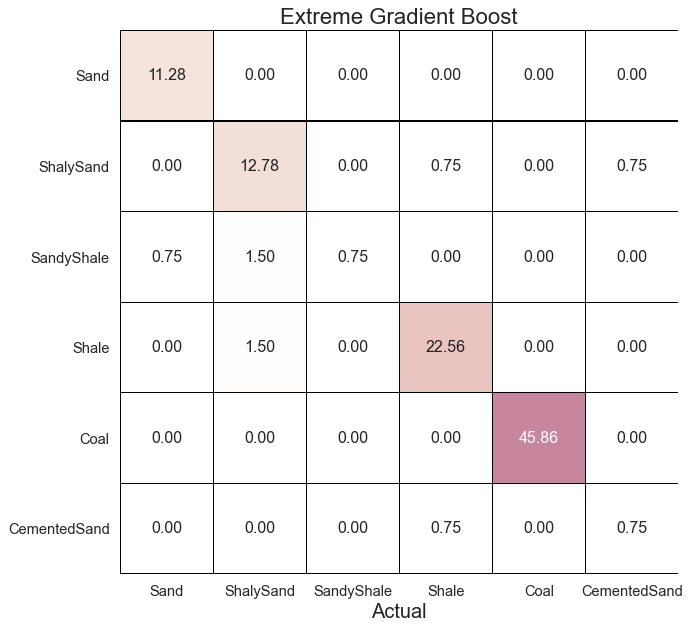

In [253]:
# Plot confusion matrix in a beautiful manner

Lith= ['Sand', 'ShalySand', 'SandyShale', 'Shale', 'Coal', 'CementedSand']
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

fig = plt.figure(num=None, figsize=(9, 9), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()

sns.heatmap(cm_gb, annot=True, vmin=0.0, vmax=100.0,
                  xticklabels = Lith, yticklabels = Lith,
                  fmt='.2f', cmap=cmap, cbar_kws={"shrink": .82},
                  linewidths=0.1, linecolor='black', cbar=False);

plt.yticks(rotation=0)
ax.set_title('Extreme Gradient Boost', fontsize = 20)
plt.xlabel('Actual', fontsize = 18) # x-axis label with fontsize 15
#plt.ylabel('Predicted', fontsize = 18) # y-axis label with fontsize 15

plt.show()
fig.savefig('cm_gb.png')

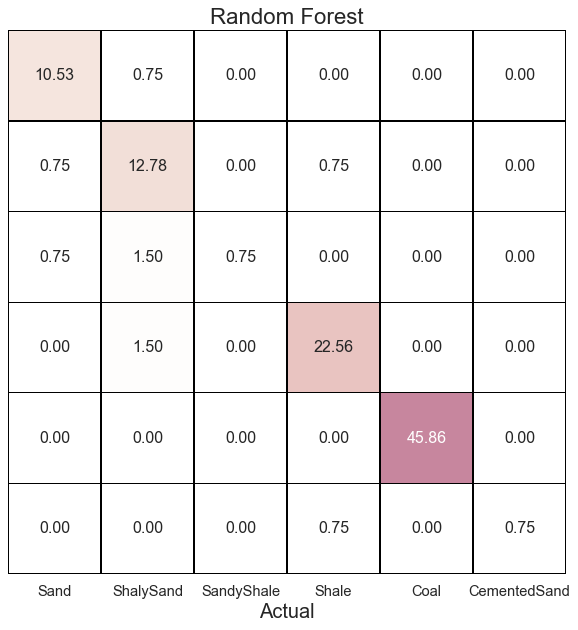

In [217]:
fig = plt.figure(num=None, figsize=(9, 9), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes()

sns.heatmap(cm_rf, annot=True, vmin=0.0, vmax=100.0,
                  xticklabels = Lith, yticklabels=False,
                  fmt='.2f', cmap=cmap, cbar_kws={"shrink": .82},
                  linewidths=0.1, linecolor='black', cbar=False);

plt.yticks(rotation=0)
ax.set_title('Random Forest', fontsize = 20)
plt.xlabel('Actual', fontsize = 18) # x-axis label with fontsize 15

plt.show()
fig.savefig('cm_rf.png')

In [282]:
# creating the dataframe
df = pd.DataFrame(data = {'xgb':np.diag(cm_gb), 'rf':np.diag(cm_rf)})
# displaying the dataframe
print(df)

         xgb         rf
0  11.278195  10.526316
1  12.781955  12.781955
2   0.751880   0.751880
3  22.556391  22.556391
4  45.864662  45.864662
5   0.751880   0.751880


In [292]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

#chi_square test for the accuracies
stat, p, dof, expected = chi2_contingency(df)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

#https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

dof=5
[[10.9460398  10.85847148]
 [12.83328804 12.73062174]
 [ 0.7548993   0.7488601 ]
 [22.64697889 22.46580306]
 [46.04885708 45.68046623]
 [ 0.7548993   0.7488601 ]]
probability=0.950, critical=11.070, stat=0.023
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)
